1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям.
3. Постройте модель предсказания 1-й точки от текущей (h=1).
4. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [50]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [51]:
d_brent_data = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]
brent_data['brent_diff'] = 0
brent_data['brent_diff'] = brent_data['brent_diff'].astype('float')
brent_data['brent_diff'].values[1:] = d_brent_data

In [52]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()

,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [53]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()

,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [54]:
d_rub_doll = rub_doll['curs'].values[1:]- rub_doll['curs'].values[:-1]
d_rub_e = rub_e['curs'].values[1:]- rub_e['curs'].values[:-1]

In [55]:
rub_doll.columns = ['USD']

In [56]:
rub_e.columns = ['EUR']

In [57]:
rub_doll['usd_diff'] = 0
rub_doll['usd_diff'] = rub_doll['usd_diff'].astype('float')
rub_doll['usd_diff'].values[1:] = d_rub_doll

In [58]:
rub_e['eur_diff'] = 0
rub_e['eur_diff'] = rub_e['eur_diff'].astype('float')
rub_e['eur_diff'].values[1:] = d_rub_e

In [59]:
brent_data = brent_data.rename(columns = {'Значение':'Brent'})

In [60]:
new_df = pd.merge(brent_data, rub_doll, how='inner', left_index=True, right_index=True)

In [61]:
new_df = pd.merge(new_df, rub_e, how='inner', left_index=True, right_index=True)

In [62]:
new_df.drop(['dayofmonth', 'dayofyear', 'dayofweek',  
             'is_prev_holiday', 'is_next_holiday'], axis=1,inplace = True)

In [63]:
brent_weekly = new_df.resample("W").mean()

In [64]:
brent_weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 11 columns):
Brent         461 non-null float64
year          461 non-null float64
month         461 non-null float64
quarter       461 non-null float64
weekofyear    461 non-null float64
is_holiday    461 non-null float64
brent_diff    461 non-null float64
USD           461 non-null float64
usd_diff      461 non-null float64
EUR           461 non-null float64
eur_diff      461 non-null float64
dtypes: float64(11)
memory usage: 44.1 KB


In [65]:
brent_weekly.dropna(inplace=True)

In [66]:
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

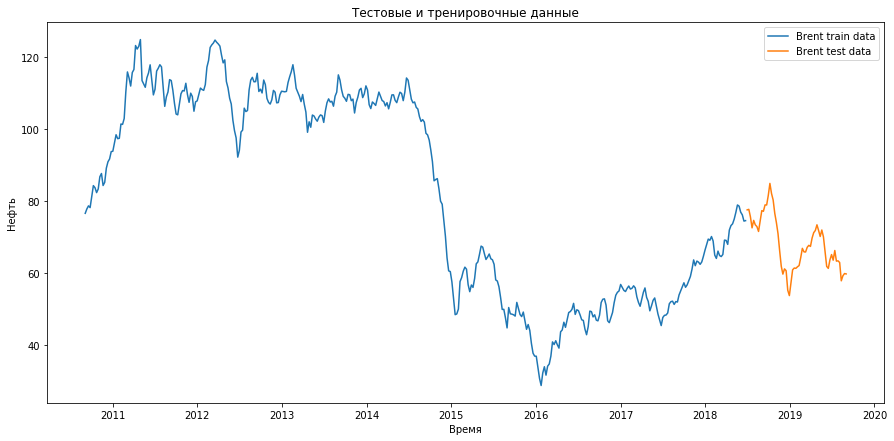

In [67]:
train, test = split_data( brent_weekly[-2000:], -61)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='Brent train data' )
plt.plot(test.index,test.iloc[:,0], label='Brent test data')

plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [68]:
h = 1

X_train = train.iloc[:-h,:]
y_train = train['Brent'].values[h:]
X_test = test.iloc[:-h,:]
y_test = test['Brent'].values[h:]

In [69]:
from sklearn.ensemble import GradientBoostingRegressor

In [70]:
model_g = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

In [71]:
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [72]:
y_test_pred_g = model_g.predict(X_test)

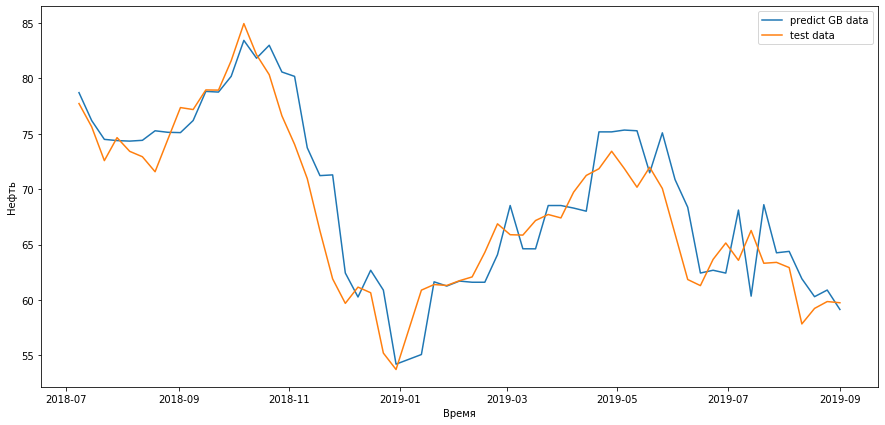

In [73]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(test.index[h:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

In [74]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [75]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   9.935540113177241 
ошибка mae  :   2.405692002379136 
оценка R2 :   0.8082881664627551


In [76]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [77]:
er_g = mean_absolute_percentage_error(y_test, y_test_pred_g)

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   3.6206582360317743 %


In [78]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2, 1, 4, 5], 
              "n_estimators":[100, 200, 300, 400, 500]}

#  randomized search
n_iter_search = 20

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.736 (std: 0.237)
Parameters: {'n_estimators': 500, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.735 (std: 0.243)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.733 (std: 0.244)
Parameters: {'n_estimators': 400, 'max_depth': 1}



In [79]:
model_g_opt = GradientBoostingRegressor(max_depth=1, random_state=0, n_estimators=500)

In [80]:
model_g_opt.fit( X_train, y_train ) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [81]:
y_test_pred_g = model_g_opt.predict(X_test)

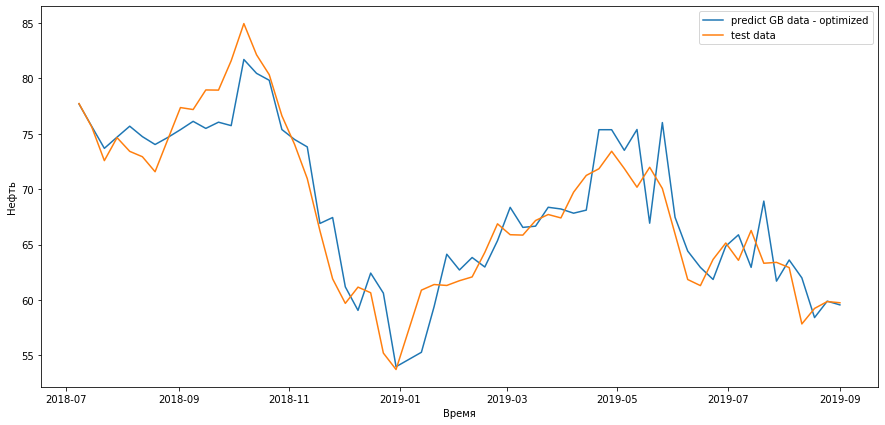

In [82]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(test.index[h:],y_test_pred_g, label='predict GB data - optimized' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

In [83]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   7.212253343423589 
ошибка mae  :   2.1081988529122078 
оценка R2 :   0.860835516071335


In [84]:
er_g = mean_absolute_percentage_error(y_test, y_test_pred_g)

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   3.131745746960693 %


Ошибка прогноза на недельных данных значительно ниже, чем на дневных данных. R2 очень большой для таких данных, как рыночные цены. Но у меня сомнения, что данные независимые - не являются ли курсы рубль-доллар рубль-евро производными от цены на нефть, а мы в данном случае используем их как входные данные.  